# CNN Tutorial V2: From Basics to AlexNet

**Deep Learning - University of Vermont**

## Learning Objectives
1.  **Implement and explain the convolution operation**, including how stride and padding affect output dimensions and why weight sharing reduces parameters.
2.  **Calculate parameters** for any CNN layer (convolutional, pooling, fully connected) and analyze how architecture choices affect model size.
3.  **Compare CNN architectures** (LeNet vs AlexNet) and explain how depth, filter size, and layer arrangement impact performance and parameter count.
4.  **Interpret CNN learned representations** by visualizing filters and feature maps to understand the hierarchical feature learning process.
5.  **Train and Compare models**: Train MLP, Simple CNN, LeNet, and AlexNet on Fashion-MNIST.



## 0. Setup and Utilities

We'll start by importing necessary libraries, setting the device (GPU/CPU), and defining a shared training function to keep our code clean.



In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

# Device configuration: Use GPU if available for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# Shared Training Function
# ==========================================
def train_model(model, train_loader, test_loader, epochs=5, lr=0.01, name="Model"):
    """
    Generic training loop for PyTorch models.
    Args:
        model: The neural network to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for validation data
        epochs: Number of passes through the dataset
        lr: Learning rate for SGD optimizer
        name: Name of the model for printing
    Returns:
        acc: Final test accuracy
        duration: Total training time in seconds
    """
    model = model.to(device) # Move model to GPU/CPU
    criterion = nn.CrossEntropyLoss() # Standard loss for classification
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) # Stochastic Gradient Descent
    
    print(f"\nTraining {name} for {epochs} epochs...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train() # Set model to training mode (enables Dropout, BatchNorm, etc.)
        running_loss = 0.0
        
        for images, labels in train_loader:
            # Move batch to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad() # Clear previous gradients
            outputs = model(images) # Compute predictions
            loss = criterion(outputs, labels) # Compute loss
            
            # Backward pass and optimization
            loss.backward() # Compute gradients
            optimizer.step() # Update weights
            
            running_loss += loss.item()
            
        print(f"  Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
            
    end_time = time.time()
    duration = end_time - start_time
    
    # Evaluation Phase
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient calculation for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # Get class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    acc = 100 * correct / total
    print(f"{name} - Accuracy: {acc:.2f}%, Time: {duration:.2f}s")
    return acc, duration

# Dictionary to store results for final comparison
results = {}

Using device: cuda


In [2]:
# ==========================================
# Data Preparation
# ==========================================
# Standard transform for MLP, SimpleCNN, LeNet (28x28 input)
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Batch size of 256 is good for GPU utilization
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

print("Data loaded successfully.")

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.9MB/s]

Data loaded successfully.


## 1. The Convolution Operation

The core of a CNN is the **convolution** operation. 

*   **Stride**: How many pixels the kernel moves at a time.
*   **Padding**: Adding zeros around the border to preserve spatial dimensions.
*   **Weight Sharing**: The same kernel weights are used across the entire image, drastically reducing parameters compared to MLPs.

### Output Dimension Formula
$$ Output = \lfloor \frac{Input - Kernel + 2 \times Padding}{Stride} \rfloor + 1 $$



In [3]:
def corr2d(X, K):
    """
    Compute 2D cross-correlation (convolution).
    X: Input tensor
    K: Kernel tensor
    """
    h, w = K.shape
    # Calculate output shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    
    # Slide kernel over input
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            # Element-wise multiplication and sum
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

# Edge Detection Example
# Create a 6x8 image with a vertical edge
X = torch.ones((6, 8))
X[:, 2:6] = 0 # Middle columns are 0 (black), sides are 1 (white)

# Define a kernel that detects vertical edges
# 1  -1
K = torch.tensor([[1.0, -1.0]])

Y = corr2d(X, K)

print("Input Image (X):\n", X)
print("\nKernel (K):\n", K)
print("\nOutput Feature Map (Y):\n", Y)
print("\nNote: Non-zero values in Y indicate where the edge is located.")



Input Image (X):
 tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

Kernel (K):
 tensor([[ 1., -1.]])

Output Feature Map (Y):
 tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

Note: Non-zero values in Y indicate where the edge is located.


## 2. Parameter Calculation Practice

Understanding model size is crucial.

**Formulas:**
*   **Conv Layer**: $(K \times K \times C_{in} + 1) \times C_{out}$ (where $+1$ is for bias)
*   **FC Layer**: $(N_{in} + 1) \times N_{out}$
*   **Pooling**: 0 parameters



In [4]:
def count_conv_params(in_channels, out_channels, kernel_size, has_bias=True):
    """Calculate parameters for a convolutional layer"""
    # Weights: (kernel_height * kernel_width * in_channels) * out_channels
    weights = in_channels * out_channels * kernel_size * kernel_size
    # Bias: 1 bias per output channel
    bias = out_channels if has_bias else 0
    return weights + bias

def count_fc_params(in_features, out_features, has_bias=True):
    """Calculate parameters for a fully connected layer"""
    # Weights: in_features * out_features
    weights = in_features * out_features
    # Bias: 1 bias per output feature
    bias = out_features if has_bias else 0
    return weights + bias

print("Parameter Calculation Examples\n" + "="*60)

# 1. LeNet Conv1
# Input: 1 channel (grayscale), Output: 6 channels, Kernel: 5x5
p1 = count_conv_params(1, 6, 5)
print(f"1. LeNet Conv1 (1->6, 5x5): {p1} params")
print(f"   Calculation: (1 * 5 * 5 + 1) * 6 = {p1}")

# 2. LeNet Conv2
# Input: 6 channels, Output: 16 channels, Kernel: 5x5
p2 = count_conv_params(6, 16, 5)
print(f"\n2. LeNet Conv2 (6->16, 5x5): {p2} params")
print(f"   Calculation: (6 * 5 * 5 + 1) * 16 = {p2}")

# 3. AlexNet Conv1
# Input: 1 channel (adapted), Output: 96 channels, Kernel: 11x11
p3 = count_conv_params(1, 96, 11)
print(f"\n3. AlexNet Conv1 (1->96, 11x11): {p3:,} params")

# 4. LeNet FC1
# Input: 16 channels * 5 * 5 spatial size = 400 features
p4 = count_fc_params(16*5*5, 120)
print(f"\n4. LeNet FC1 (400->120): {p4:,} params")

# 5. MLP Comparison
mlp_p = count_fc_params(28*28, 256)
cnn_p = count_conv_params(1, 64, 3)
print(f"\n5. MLP (784->256) vs CNN (1->64, 3x3):")
print(f"   MLP: {mlp_p:,} params")
print(f"   CNN: {cnn_p:,} params")
print(f"   Reduction: {mlp_p/cnn_p:.1f}x fewer parameters in the first layer!")



Parameter Calculation Examples
1. LeNet Conv1 (1->6, 5x5): 156 params
   Calculation: (1 * 5 * 5 + 1) * 6 = 156

2. LeNet Conv2 (6->16, 5x5): 2416 params
   Calculation: (6 * 5 * 5 + 1) * 16 = 2416

3. AlexNet Conv1 (1->96, 11x11): 11,712 params

4. LeNet FC1 (400->120): 48,120 params

5. MLP (784->256) vs CNN (1->64, 3x3):
   MLP: 200,960 params
   CNN: 640 params
   Reduction: 314.0x fewer parameters in the first layer!


## 3. Multi-Layer Perceptron (MLP)

### 3.1 Overview
We start with a standard MLP to establish a baseline. 
*   **Limitation**: MLPs require flattening the 2D image into a 1D vector ($28 \times 28 = 784$). This destroys spatial relationships (e.g., pixel (0,0) is far from (0,1) in the vector if not careful, and completely separated from (1,0)).
*   **Architecture**: Input (784) -> Hidden (256) -> ReLU -> Output (10).



In [5]:
# ==========================================
# MLP Implementation
# ==========================================
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Flatten: Converts 2D image (28x28) to 1D vector (784)
        self.flatten = nn.Flatten()
        
        # Fully Connected Layer 1: 784 inputs -> 256 hidden units
        # This layer alone has 784*256 + 256 = 200,960 parameters!
        self.fc1 = nn.Linear(28*28, 256)
        
        # Activation Function: ReLU (Rectified Linear Unit)
        self.relu = nn.ReLU()
        
        # Fully Connected Layer 2: 256 hidden -> 10 output classes
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # x shape: [batch_size, 1, 28, 28]
        x = self.flatten(x)        # -> [batch_size, 784]
        x = self.relu(self.fc1(x)) # -> [batch_size, 256]
        x = self.fc2(x)            # -> [batch_size, 10]
        return x

# Initialize and Train
mlp = MLP()
acc, t = train_model(mlp, train_loader, test_loader, epochs=5, name="MLP")
results['MLP'] = (acc, t)


Training MLP for 5 epochs...
  Epoch [1/5], Loss: 1.7472
  Epoch [2/5], Loss: 1.0769
  Epoch [3/5], Loss: 0.8681
  Epoch [4/5], Loss: 0.7729
  Epoch [5/5], Loss: 0.7140
MLP - Accuracy: 75.37%, Time: 28.40s


## 4. Simple CNN

### 4.1 Overview
A basic CNN to demonstrate the components:
1.  **Convolution**: Extracts features.
2.  **Pooling**: Reduces spatial size (downsampling).
3.  **Flatten**: Prepares for classification.
4.  **Linear**: Classifies based on features.

**Architecture**: Conv (32 filters) -> Pool -> Conv (64 filters) -> Pool -> FC.



In [6]:
# ==========================================
#  CNN Implementation
# ==========================================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Block 1: Conv -> ReLU -> MaxPool
        # Input: 1x28x28
        # Conv1: 32 filters, 3x3 kernel, padding=1 (preserves size)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # MaxPool: 2x2 kernel, stride 2 (halves size: 28->14)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2: Conv -> ReLU -> MaxPool
        # Input: 32x14x14
        # Conv2: 64 filters, 3x3 kernel
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # MaxPool: 14->7
        
        # Classifier
        self.flatten = nn.Flatten()
        # Input features: 64 channels * 7 * 7 spatial size
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x) # -> 32x14x14
        
        # Block 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) # -> 64x7x7
        
        # Classifier
        x = self.flatten(x) # -> 3136
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize and Train
cnn = SimpleCNN()
acc, t = train_model(cnn, train_loader, test_loader, epochs=5, name="Simple CNN")
results['Simple CNN'] = (acc, t)


Training Simple CNN for 5 epochs...
  Epoch [1/5], Loss: 1.8294
  Epoch [2/5], Loss: 0.8653
  Epoch [3/5], Loss: 0.7417
  Epoch [4/5], Loss: 0.6727
  Epoch [5/5], Loss: 0.6399
Simple CNN - Accuracy: 73.76%, Time: 33.12s


## 5. LeNet-5 (1998)

### 5.1 Historical Context
Proposed by Yann LeCun in 1998, LeNet-5 was one of the first successful CNNs, used for reading zip codes on mail (MNIST).

### 5.2 Architecture
```
Input (1×28×28)
  ↓
Conv1: 5×5, 6 filters → (6×28×28)
  ↓ Sigmoid
AvgPool: 2×2 → (6×14×14)
  ↓
Conv2: 5×5, 16 filters → (16×10×10)
  ↓ Sigmoid
AvgPool: 2×2 → (16×5×5)
  ↓ Flatten
FC1: 120 units
  ↓ Sigmoid
FC2: 84 units
  ↓ Sigmoid
FC3: 10 units (output)
```
*   **Activation**: Sigmoid 



In [ ]:
# ==========================================
# LeNet-5 Implementation
# ==========================================
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Feature Extractor (Convolutional Part)
        self.feature_extractor = nn.Sequential(
            # C1: 1 input channel -> 6 output channels, 5x5 kernel
            # Padding=2 to handle 28x28 input (simulating 32x32)
            nn.Conv2d(1, 6, kernel_size=5, padding=2), 
            nn.Sigmoid(), # Original LeNet used Sigmoid/Tanh
            
            # S2: Average Pooling (2x2)
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            # C3: 6 -> 16 channels, 5x5 kernel
            nn.Conv2d(6, 16, kernel_size=5), 
            nn.Sigmoid(),
            
            # S4: Average Pooling (2x2)
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier (Fully Connected Part)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Input: 16 channels * 5 * 5 spatial size
            nn.Linear(16 * 5 * 5, 120), 
            nn.Sigmoid(),
            nn.Linear(120, 84), 
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

# Initialize and Train
lenet = LeNet()
acc, t = train_model(lenet, train_loader, test_loader, epochs=5, name="LeNet")
results['LeNet'] = (acc, t)


Training LeNet for 5 epochs...
  Epoch [1/5], Loss: 2.3071
  Epoch [2/5], Loss: 2.3028
  Epoch [3/5], Loss: 2.3029
  Epoch [4/5], Loss: 2.3028
  Epoch [5/5], Loss: 2.3028
LeNet - Accuracy: 10.00%, Time: 30.54s


### 5.3 Visualizing Feature Maps
LeNet is small enough that we can easily visualize what it learns.



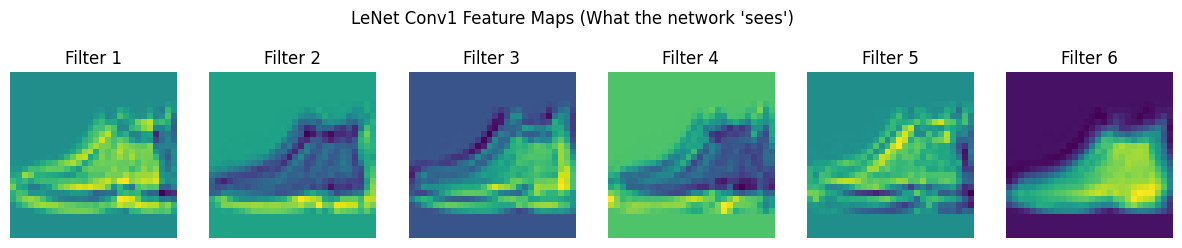

In [8]:
def visualize_feature_maps(model, img):
    """Visualize the output of the first convolutional layer"""
    model.eval()
    with torch.no_grad():
        # Prepare image
        x = img.unsqueeze(0).to(device)
        
        # Pass through first layer (Conv1 + Sigmoid)
        # feature_extractor[0] is Conv2d(1, 6, ...)
        # feature_extractor[1] is Sigmoid()
        x = model.feature_extractor[0](x)
        x = model.feature_extractor[1](x)
        
        # Plot
        fig, axes = plt.subplots(1, 6, figsize=(15, 3))
        for i in range(6):
            axes[i].imshow(x[0, i].cpu(), cmap='viridis')
            axes[i].set_title(f'Filter {i+1}')
            axes[i].axis('off')
        plt.suptitle("LeNet Conv1 Feature Maps (What the network 'sees')")
        plt.show()

# Get a sample image from test set
img, _ = test_set[0]
visualize_feature_maps(lenet, img)

## 6. AlexNet (2012)

### 6.1 Historical Context
> "AlexNet, which employed an 8-layer CNN, won the ImageNet Large Scale Visual Recognition Challenge 2012 by a large margin. This network showed, for the first time, that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision."

### 6.2 Key Innovations
1.  **Depth**: 8 layers (5 Conv + 3 FC), much deeper than LeNet.
2.  **ReLU**: Rectified Linear Unit ($max(0,x)$) solved the vanishing gradient problem of Sigmoid, allowing faster training of deep nets.
3.  **Dropout**: Randomly dropping neurons during training to prevent overfitting.
4.  **Data Augmentation**: Flipping and cropping images to increase dataset size.
5.  **GPU**: Trained on two GTX 580 GPUs (3GB each).

### 6.3 Architecture
```
Input (1×224×224 for Fashion-MNIST, adapted)
  ↓
Conv1: 11×11, 96 filters, stride=4
  ↓ ReLU → MaxPool
Conv2: 5×5, 256 filters
  ↓ ReLU → MaxPool
Conv3: 3×3, 384 filters
  ↓ ReLU
Conv4: 3×3, 384 filters
  ↓ ReLU
Conv5: 3×3, 256 filters
  ↓ ReLU → MaxPool
  ↓ Flatten
FC1: 4096 units
  ↓ ReLU → Dropout
FC2: 4096 units
  ↓ ReLU → Dropout
FC3: 10 units
```



In [9]:
# ==========================================
# AlexNet Implementation
# ==========================================
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            # Conv1: Large 11x11 filters to capture global patterns
            # Stride 4 reduces dimension quickly (224 -> 55)
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv2: 5x5 filters
            nn.Conv2d(96, 256, kernel_size=5, padding=2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv3, 4, 5: Stacked convolutions without pooling
            nn.Conv2d(256, 384, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            
            # Dropout: Randomly zero out 50% of neurons to prevent overfitting
            nn.Dropout(p=0.5),
            nn.Linear(256 * 5 * 5, 4096), 
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), 
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, 10) # 10 output classes for Fashion-MNIST
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("AlexNet defined.")

AlexNet defined.


### 6.4 Training AlexNet
**Note**: AlexNet requires 224x224 input. Fashion-MNIST is 28x28. We must resize the images.
We also use a smaller batch size because AlexNet is memory intensive.



In [10]:
# Prepare Data for AlexNet (Resize to 224x224)
print("Preparing data for AlexNet (Resizing to 224x224)...")
transform_alex = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

# We use a subset for demonstration speed, or full set if you have time/GPU
# Here we use the full set but only 1 epoch
train_set_alex = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_alex)
test_set_alex = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_alex)

# Smaller batch size to avoid Out of Memory
train_loader_alex = DataLoader(train_set_alex, batch_size=64, shuffle=True)
test_loader_alex = DataLoader(test_set_alex, batch_size=64, shuffle=False)

# Initialize and Train
# Note: We only train for 1 epoch here because it's very slow on CPU/small GPUs!
alexnet = AlexNet()
acc, t = train_model(alexnet, train_loader_alex, test_loader_alex, epochs=5, name="AlexNet")
results['AlexNet'] = (acc, t)

Preparing data for AlexNet (Resizing to 224x224)...

Training AlexNet for 5 epochs...
  Epoch [1/5], Loss: 2.3011
  Epoch [2/5], Loss: 1.4436
  Epoch [3/5], Loss: 0.7645
  Epoch [4/5], Loss: 0.6028
  Epoch [5/5], Loss: 0.5282
AlexNet - Accuracy: 79.32%, Time: 269.69s


# 7. Architecture Comparison and Analysis

### 7.1 Performance & Efficiency
Let's compare the accuracy, training time, and parameter count of all four models.



In [11]:
print(f"{'Model':<15} {'Accuracy':<10} {'Time (s)':<10} {'Parameters':<15}")
print("-" * 55)

for name, (acc, t) in results.items():
    if name == "MLP": model = mlp
    elif name == "Simple CNN": model = cnn
    elif name == "LeNet": model = lenet
    elif name == "AlexNet": model = alexnet
    
    # Calculate total parameters
    params = sum(p.numel() for p in model.parameters())
    print(f"{name:<15} {acc:<10.2f} {t:<10.2f} {params:<15,}")

print("-" * 55)
print("\nAnalysis:")
print("1. MLP: High parameter count due to dense connections, but no spatial awareness.")
print("2. Simple CNN: Better than MLP with fewer parameters.")
print("3. LeNet: Extremely efficient (smallest model). Good for simple tasks like this.")
print("4. AlexNet: Massive parameter count. Overkill for Fashion-MNIST, but necessary for ImageNet.")

Model           Accuracy   Time (s)   Parameters     
-------------------------------------------------------
MLP             75.37      28.40      203,530        
Simple CNN      73.76      33.12      421,642        
LeNet           10.00      30.54      61,706         
AlexNet         79.32      269.69     46,764,746     
-------------------------------------------------------

Analysis:
1. MLP: High parameter count due to dense connections, but no spatial awareness.
2. Simple CNN: Better than MLP with fewer parameters.
3. LeNet: Extremely efficient (smallest model). Good for simple tasks like this.
4. AlexNet: Massive parameter count. Overkill for Fashion-MNIST, but necessary for ImageNet.


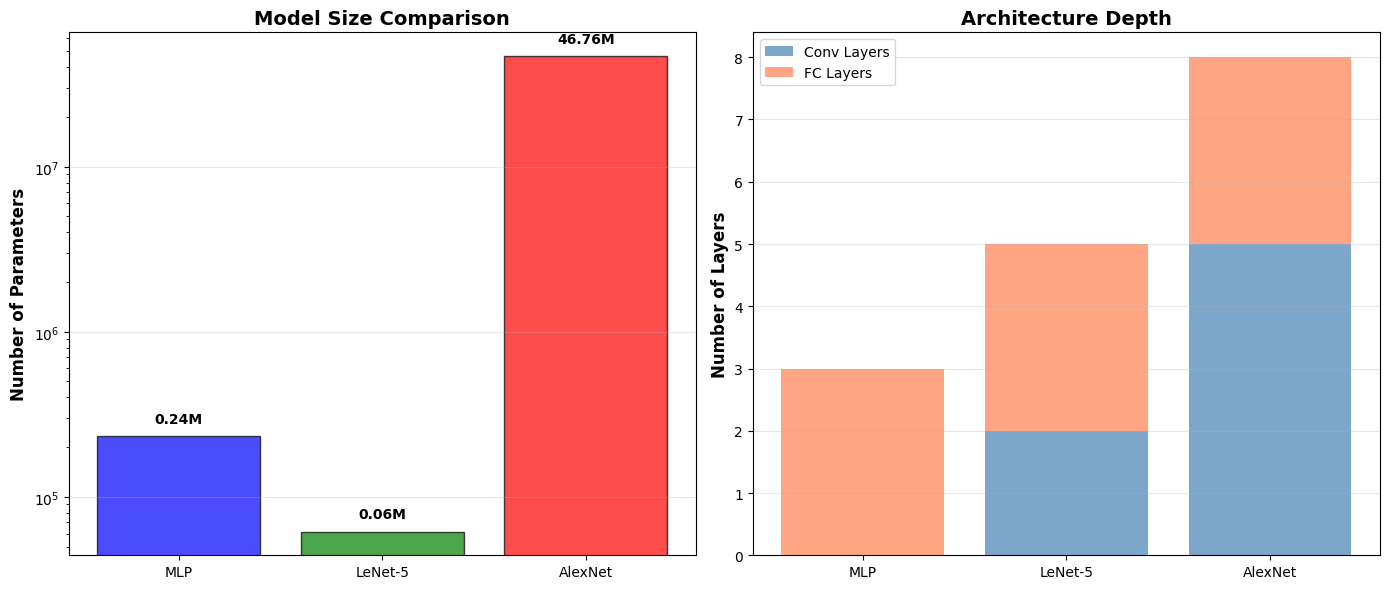


Model           Parameters      Conv Layers     FC Layers
MLP                  235,146              0            3
LeNet-5               61,706              2            3
AlexNet           46,764,746              5            3


In [12]:
# ==========================================
# 7.2 Visualizing Model Size & Depth
# ==========================================
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Build a specific MLP for this comparison (matches the graph requirements)
class MLP_Comparison(nn.Module):
    def __init__(self):
        super(MLP_Comparison, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mlp_comp = MLP_Comparison()

# Compare parameters
# We use the models we defined/trained earlier, plus this specific MLP
models = {
    'MLP': mlp_comp,
    'LeNet-5': lenet.cpu(),
    'AlexNet': alexnet.cpu()
}

results_param = {}
for name, model in models.items():
    params = sum(p.numel() for p in model.parameters())
    results_param[name] = params

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Parameter count
names = list(results_param.keys())
params = list(results_param.values())
colors = ['blue', 'green', 'red']

ax1.bar(names, params, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Parameters', fontsize=12, fontweight='bold')
ax1.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
ax1.set_yscale('log') # Log scale to handle the massive difference
ax1.grid(True, axis='y', alpha=0.3)

for i, (name, param) in enumerate(zip(names, params)):
    ax1.text(i, param * 1.2, f'{param/1e6:.2f}M', ha='center', fontweight='bold')

# 2. Architecture comparison (Depth)
arch_info = {
    'MLP': {'Conv Layers': 0, 'FC Layers': 3},
    'LeNet-5': {'Conv Layers': 2, 'FC Layers': 3},
    'AlexNet': {'Conv Layers': 5, 'FC Layers': 3}
}

x_pos = np.arange(len(names))
conv_counts = [arch_info[n]['Conv Layers'] for n in names]
fc_counts = [arch_info[n]['FC Layers'] for n in names]

ax2.bar(x_pos, conv_counts, label='Conv Layers', color='steelblue', alpha=0.7)
ax2.bar(x_pos, fc_counts, bottom=conv_counts, label='FC Layers', color='coral', alpha=0.7)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(names)
ax2.set_ylabel('Number of Layers', fontsize=12, fontweight='bold')
ax2.set_title('Architecture Depth', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print(f"{'Model':<15} {'Parameters':<15} {'Conv Layers':<15} {'FC Layers'}")
print("="*70)
for name in names:
    print(f"{name:<15} {results_param[name]:>12,}   {arch_info[name]['Conv Layers']:>12}   {arch_info[name]['FC Layers']:>10}")
print("="*70)



In [13]:
# ==========================================
# 7.3 Detailed Architecture Comparison
# ==========================================
comparison = {
    'Aspect': [
        'Year',
        'Total Layers',
        'Conv Layers',
        'FC Layers',
        'First Conv Kernel',
        'Activation',
        'Pooling',
        'Regularization',
        'Total Parameters',
        'Conv Parameters',
        'FC Parameters',
        'Input Size',
        'Dataset'
    ],
    'LeNet-5': [
        '1998',
        '7 (2 conv + 3 FC + 2 pool)',
        '2',
        '3',
        '5×5',
        'Sigmoid',
        'Average Pooling',
        'None',
        '~60K',
        '~3K',
        '~57K',
        '28×28 (grayscale)',
        'MNIST (60K images)'
    ],
    'AlexNet': [
        '2012',
        '8 (5 conv + 3 FC)',
        '5',
        '3',
        '11×11, stride=4',
        'ReLU',
        'Max Pooling',
        'Dropout (0.5)',
        '~46M',
        '~2.3M',
        '~43.7M',
        '224×224 (RGB)',
        'ImageNet (1.2M images)'
    ]
}

print("\n" + "="*100)
print("LeNet-5 vs AlexNet: Complete Comparison")
print("="*100)
print(f"{'Aspect':<25} {'LeNet-5':<35} {'AlexNet':<35}")
print("="*100)

for i, aspect in enumerate(comparison['Aspect']):
    print(f"{aspect:<25} {comparison['LeNet-5'][i]:<35} {comparison['AlexNet'][i]:<35}")

print("="*100)

print("\n💡 Key Architectural Differences:\n")
print("1. DEPTH:")
print("   • LeNet: 2 conv layers (shallow)")
print("   • AlexNet: 5 conv layers (deep)")
print("   • Impact: Deeper networks learn more complex hierarchical features\n")

print("2. FILTER SIZE:")
print("   • LeNet: 5×5 kernels throughout")
print("   • AlexNet: Large 11×11 first layer, then 5×5, then 3×3")
print("   • Impact: Large kernels capture broader context initially\n")

print("3. LAYER ARRANGEMENT:")
print("   • LeNet: Conv→Pool→Conv→Pool→FC→FC→FC")
print("   • AlexNet: Conv→Pool→Conv→Pool→Conv→Conv→Conv→Pool→FC→FC→FC")
print("   • Impact: More conv layers before pooling = richer features\n")

print("4. PERFORMANCE IMPACT:")
print("   • LeNet: ~99% on MNIST (simple dataset)")
print("   • AlexNet: Won ImageNet 2012 (complex, large-scale dataset)")
print("   • Impact: Depth + modern techniques = breakthrough performance")




LeNet-5 vs AlexNet: Complete Comparison
Aspect                    LeNet-5                             AlexNet                            
Year                      1998                                2012                               
Total Layers              7 (2 conv + 3 FC + 2 pool)          8 (5 conv + 3 FC)                  
Conv Layers               2                                   5                                  
FC Layers                 3                                   3                                  
First Conv Kernel         5×5                                 11×11, stride=4                    
Activation                Sigmoid                             ReLU                               
Pooling                   Average Pooling                     Max Pooling                        
Regularization            None                                Dropout (0.5)                      
Total Parameters          ~60K                                ~46M           

# 8. Exercises

Try these to deepen your understanding:

### LeNet:
1. Replace average pooling with max pooling. What happens?
2. Replace sigmoid with ReLU activations. How does performance change?
3. Try deeper networks: add more convolutional layers

### AlexNet:
4. Remove dropout from AlexNet. Does it overfit?
5. Change the learning rate. What's optimal for AlexNet?
6. AlexNet is too large for Fashion-MNIST. Simplify it while maintaining accuracy.

### Parameter Analysis:
7. Calculate by hand the parameters in the first conv layer of AlexNet
8. Why do AlexNet's FC layers have so many parameters? How could we reduce them?
9. Design a CNN with <100K parameters that achieves >85% on Fashion-MNIST